In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from tqdm import tqdm
from time import time

# TODO: Move functions to separate modules
import functions as f

import core.background_model as background_model
import core.clique_finding as cf
import core.stats 

# GLOBALS

TTN_BIN = 4275
BIN_MAP_PATH = 'mappings/bin_map_human_100000.bed'
GTF_PATH = 'mappings/gencode.v38.annotation.gtf'
GENE_BIN_PATH = 'mappings/gene_bins.txt'
NON_GENE_BIN_PATH = 'mappings/non_gene_bins.txt'


gene_bins = []
with open('mappings/gene_bins.txt', 'r') as file:
    for line in file:
        gene_bins.append(line.strip())
gene_bins = [int(x) for x in gene_bins]


non_gene_bins = []
with open('mappings/non_gene_bins.txt', 'r') as file:
    for line in file:
        non_gene_bins.append(line.strip())
non_gene_bins = [int(x) for x in non_gene_bins]



## Analytical

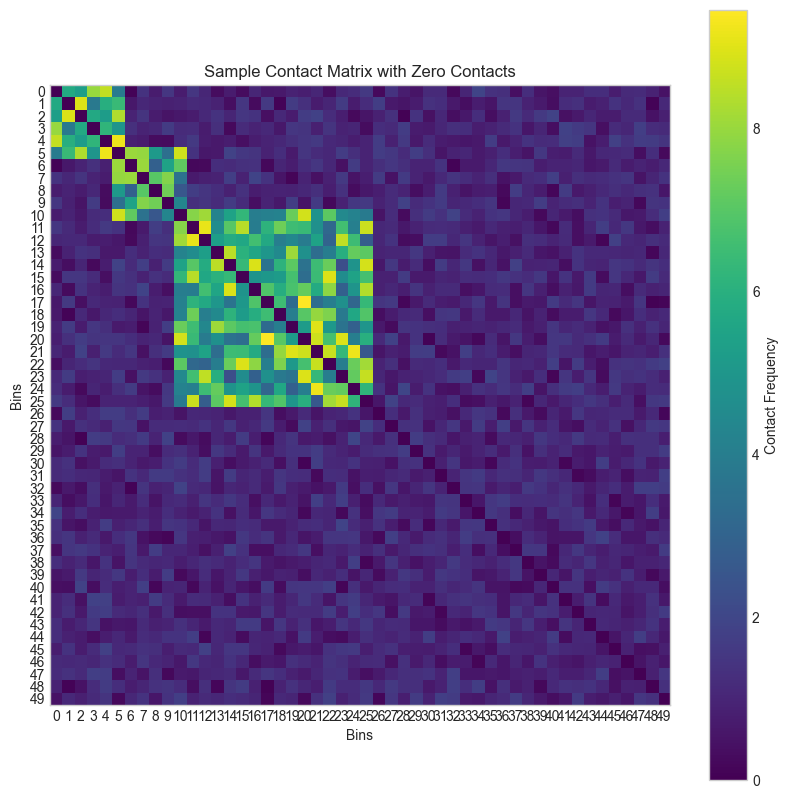

<Figure size 640x480 with 0 Axes>

In [21]:
contact_matrix_zero = f.generate_sample_matrix_bins(50)


plt.figure(figsize=(10, 10))
plt.imshow(contact_matrix_zero, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Contact Frequency')
plt.title('Sample Contact Matrix with Zero Contacts')
plt.xlabel('Bins')
plt.ylabel('Bins')
plt.xticks(ticks=np.arange(len(contact_matrix_zero)), labels=np.arange(len(contact_matrix_zero)))
plt.yticks(ticks=np.arange(len(contact_matrix_zero)), labels=np.arange(len(contact_matrix_zero)))
plt.grid(False)
plt.show()
plt.tight_layout()


In [22]:
def optimize_clique_size_analytical(
    contact_matrix: np.ndarray,
    max_clique_size: int,
    seed_bin: int,
    alpha: float,
):
    """
    For each possible seed bin i:
      – use F[i, :] to pick the top‐k visited bins as its clique
      – score those cliques against the TTN seed_bin clique
    """

    N = contact_matrix.shape[0]
    sizes = list(range(1, max_clique_size + 1))

    print("🔄 Computing full analytical diffusion matrix F…")
    F = cf.all_analytical_diffusions(contact_matrix=contact_matrix, alpha=alpha)
    # F.shape == (N, N)

    # 1) Build the TTN clique once
    ttn_full = np.argsort(F[seed_bin])[-max_clique_size:][::-1]
    print(f"✔︎ TTN seed clique (size {max_clique_size}) ready")

    # 2) Build background cliques for every possible seed i
    bg_full = [
        np.argsort(F[i])[-max_clique_size:][::-1]
        for i in range(N)
    ]
    print(f"✔︎ Built background cliques for all {N} seeds")

    # 3) Now for each size, compute scores & empirical p‐values
    ttn_scores, p_values, fold_changes = [], [], []
    bg_dists = {}

    for size in tqdm(sizes, desc="Processing sizes"):
        # TTN subclique & score
        ttn_sub = ttn_full[:size]
        ttn_score = core.stats.calculate_avg_interaction_strength(contact_matrix, ttn_sub)

        # Background scores for this same size
        bg_scores = [
            core.stats.calculate_avg_interaction_strength(contact_matrix, clique[:size])
            for clique in bg_full
        ]
        bg_dists[size] = bg_scores

        median_bg = np.median(bg_scores)
        # empirical p‐value, +1 correction
        pval = (np.sum(np.array(bg_scores) >= ttn_score) + 1) / (N + 1)
        fold  = ttn_score / median_bg if median_bg != 0 else float("nan")

        ttn_scores.append(ttn_score)
        p_values.append(pval)
        fold_changes.append(fold)

    print("✅ Done optimize_clique_size_analytical")
    return sizes, ttn_scores, p_values, fold_changes, bg_dists

In [23]:
sizes, ttn_scores, p_values, fold_changes, bg_dists = optimize_clique_size_analytical(contact_matrix_zero, 30, 3, 0.25)

🔄 Computing full analytical diffusion matrix F…
✔︎ TTN seed clique (size 30) ready
✔︎ Built background cliques for all 50 seeds


Processing sizes: 100%|██████████| 30/30 [00:00<00:00, 549.03it/s]

✅ Done optimize_clique_size_analytical


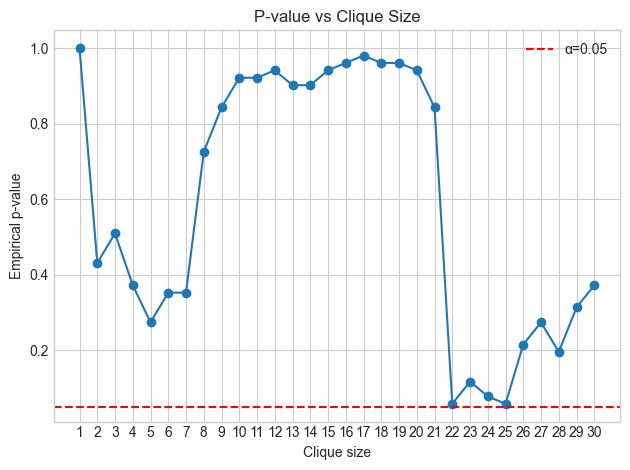

Optimal clique size = 22, p-value = 0.0588


In [24]:
import numpy as np
import matplotlib.pyplot as plt


plt.style.use('seaborn-v0_8-whitegrid')  # Clean modern look
# 1) Plot p-value vs size
plt.figure()
plt.plot(sizes, p_values, marker='o', linestyle='-')
plt.axhline(0.05, color='red', linestyle='--', label='α=0.05')
plt.xlabel('Clique size')
plt.ylabel('Empirical p-value')
plt.title('P-value vs Clique Size')
plt.xticks(sizes)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Choose the size with minimum p-value
opt_idx = int(np.argmin(p_values))
opt_size = sizes[opt_idx]
opt_pval = p_values[opt_idx]
print(f'Optimal clique size = {opt_size}, p-value = {opt_pval:.4f}')

🔄 Starting full sweep over alphas and sizes...
→ Running optimize_clique_size for α=0.01
🔄 Computing full analytical diffusion matrix F…
✔︎ TTN seed clique (size 50) ready
✔︎ Built background cliques for all 50 seeds


Processing sizes: 100%|██████████| 50/50 [00:00<00:00, 258.39it/s]


✅ Done optimize_clique_size_analytical
   • Completed α=0.01 (collected sizes 1–50)
→ Running optimize_clique_size for α=0.05
🔄 Computing full analytical diffusion matrix F…
✔︎ TTN seed clique (size 50) ready
✔︎ Built background cliques for all 50 seeds


Processing sizes: 100%|██████████| 50/50 [00:00<00:00, 268.21it/s]


✅ Done optimize_clique_size_analytical
   • Completed α=0.05 (collected sizes 1–50)
→ Running optimize_clique_size for α=0.1
🔄 Computing full analytical diffusion matrix F…
✔︎ TTN seed clique (size 50) ready
✔︎ Built background cliques for all 50 seeds


Processing sizes: 100%|██████████| 50/50 [00:00<00:00, 264.14it/s]


✅ Done optimize_clique_size_analytical
   • Completed α=0.1 (collected sizes 1–50)
→ Running optimize_clique_size for α=0.25
🔄 Computing full analytical diffusion matrix F…
✔︎ TTN seed clique (size 50) ready
✔︎ Built background cliques for all 50 seeds


Processing sizes: 100%|██████████| 50/50 [00:00<00:00, 261.62it/s]


✅ Done optimize_clique_size_analytical
   • Completed α=0.25 (collected sizes 1–50)
→ Running optimize_clique_size for α=0.5
🔄 Computing full analytical diffusion matrix F…
✔︎ TTN seed clique (size 50) ready
✔︎ Built background cliques for all 50 seeds


Processing sizes: 100%|██████████| 50/50 [00:00<00:00, 260.91it/s]


✅ Done optimize_clique_size_analytical
   • Completed α=0.5 (collected sizes 1–50)
✅ DataFrame assembled: 250 rows
📊 Plotting heatmaps...
Most significant combination:
α = 0.050, k = 23, p-value = 3.92e-02
log₁₀(p-value) = -1.407


/var/folders/db/z1b_vlyx6z50n353tspswlc80000gn/T/ipykernel_40029/898971348.py:100: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from current font.
  plt.tight_layout()
/var/folders/db/z1b_vlyx6z50n353tspswlc80000gn/T/ipykernel_40029/898971348.py:100: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/envs/expanse38/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/expanse38/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


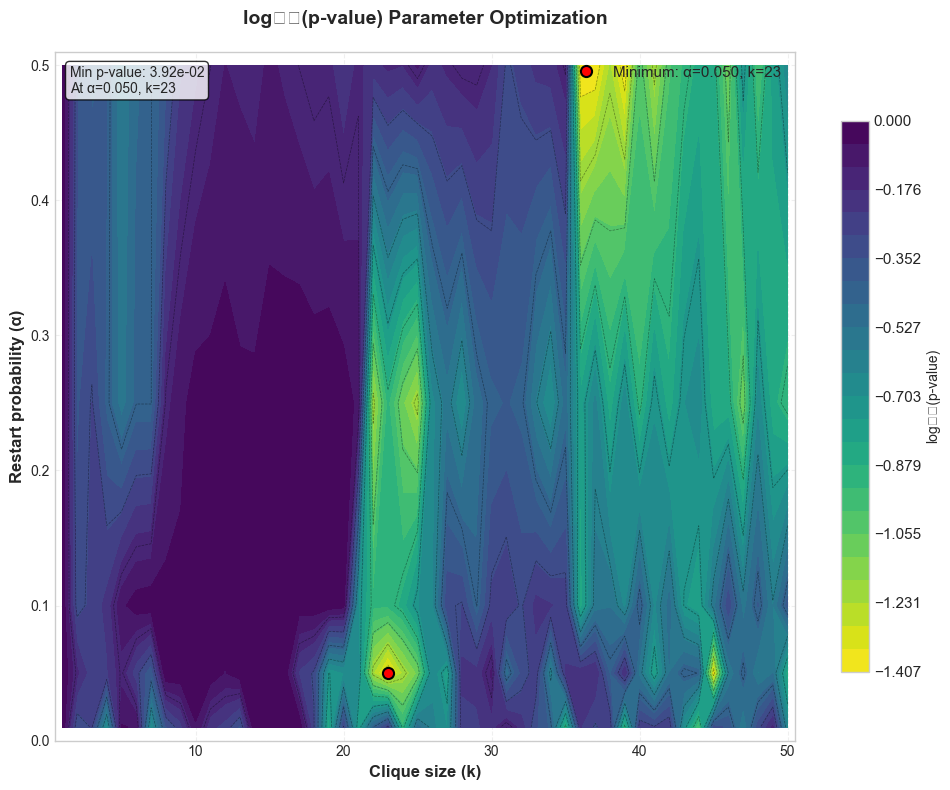

🎉 All done!
💾 CSV files saved


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Parameters ---
alphas          = [0.01, 0.05, 0.1, 0.25, 0.5]
max_clique_size = 50

print("🔄 Starting full sweep over alphas and sizes...")

# --- Collect all size-wise results ---
records = []
for alpha in alphas:
    print(f"→ Running optimize_clique_size for α={alpha}")
    sizes, scores, pvals, folds, _ = optimize_clique_size_analytical(
        contact_matrix=contact_matrix_zero,
        max_clique_size=max_clique_size,
        seed_bin=3,
        alpha=alpha,
    )
    print(f"   • Completed α={alpha} (collected sizes 1–{max_clique_size})")
    for size, pval, fold in zip(sizes, pvals, folds):
        records.append({
            'alpha': alpha,
            'size':  size,
            'pval':  pval,
            'fold':  fold
        })

df = pd.DataFrame(records)
print(f"✅ DataFrame assembled: {df.shape[0]} rows")

# --- Pivot into matrices ---
pval_mat = df.pivot(index='alpha', columns='size', values='pval')
fold_mat = df.pivot(index='alpha', columns='size', values='fold')

print("📊 Plotting heatmaps...")
# Enhanced contour plot of log10 p-value over the full grid
import numpy as np
import matplotlib.pyplot as plt

# Get data
alpha_vals = pval_mat.index.values
size_vals = pval_mat.columns.values
AA, SS = np.meshgrid(alpha_vals, size_vals, indexing='ij')
Z = np.log10(pval_mat.values)

# Find the most significant point (minimum log10 p-value)
min_idx = np.unravel_index(np.nanargmin(Z), Z.shape)
optimal_alpha = alpha_vals[min_idx[0]]
optimal_size = size_vals[min_idx[1]]
min_log_pval = Z[min_idx]
actual_pval = 10**min_log_pval

print(f"Most significant combination:")
print(f"α = {optimal_alpha:.3f}, k = {optimal_size}, p-value = {actual_pval:.2e}")
print(f"log₁₀(p-value) = {min_log_pval:.3f}")

# Create enhanced figure
plt.figure(figsize=(10, 8))

# Create contour plot with more levels for smoother appearance
levels = np.linspace(np.nanmin(Z), np.nanmax(Z), 25)
cp = plt.contourf(SS, AA, Z, levels=levels, cmap='viridis_r')

# Add contour lines for better readability
contour_lines = plt.contour(SS, AA, Z, levels=10, colors='black', alpha=0.4, linewidths=0.5)

# Enhanced colorbar
cbar = plt.colorbar(cp, label='log₁₀(p-value)', shrink=0.8)
cbar.ax.tick_params(labelsize=11)

# Mark the optimal point with professional styling
plt.plot(optimal_size, optimal_alpha, 'o', color='red', markersize=8, 
         markeredgecolor='black', markeredgewidth=1.5, 
         label=f'Minimum: α={optimal_alpha:.3f}, k={optimal_size}')

# Enhanced labels and title
plt.xlabel('Clique size (k)', fontsize=12, fontweight='bold')
plt.ylabel('Restart probability (α)', fontsize=12, fontweight='bold')
plt.title('log₁₀(p-value) Parameter Optimization', 
          fontsize=14, fontweight='bold', pad=20)

# Add grid for better readability
plt.grid(True, alpha=0.3, linestyle='--')

# Legend
plt.legend(loc='upper right', fontsize=11, framealpha=0.9)

# Set axis limits with some padding
plt.xlim(size_vals.min() - 0.5, size_vals.max() + 0.5)
plt.ylim(alpha_vals.min() - 0.01, alpha_vals.max() + 0.01)

# Add text box with statistics
textstr = f'Min p-value: {actual_pval:.2e}\nAt α={optimal_alpha:.3f}, k={optimal_size}'
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()




print("🎉 All done!")


# Save main DataFrame
# df.to_csv("sweep_results_2.csv", index=False)

# Save pivoted matrices
pval_mat.to_csv("pval_matrix2.csv")
# fold_mat.to_csv("fold_matrix2.csv")

print("💾 CSV files saved")

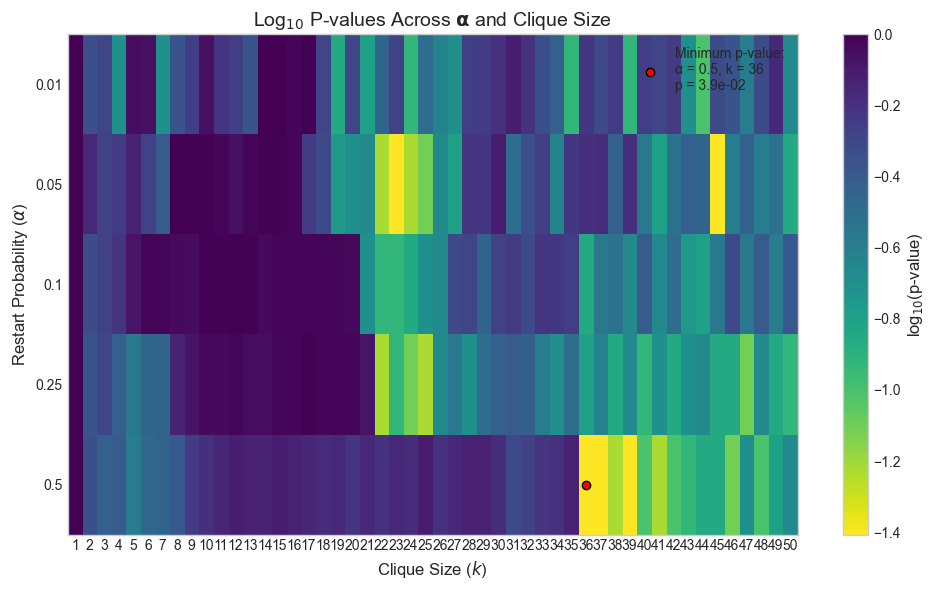

In [40]:

def plot_pval_heatmap(csv_path):
    # Load and preprocess data
    df = pd.read_csv(csv_path)
    df.set_index('alpha', inplace=True)

    # Compute log10 of p-values (clip to avoid log(0))
    log_df = np.log10(df.clip(lower=1e-300))

    # Find minimum p-value and its coordinates
    min_val = df.min().min()
    min_alpha, min_size = None, None
    for alpha in df.index:
        for size in df.columns:
            if df.loc[alpha, size] == min_val:
                min_alpha = alpha
                min_size = int(size)
                break

    # Plot configuration
    plt.figure(figsize=(10, 6))
    im = plt.imshow(log_df.values, cmap="viridis_r", aspect='auto')

    # Axis ticks and labels
    plt.xticks(ticks=np.arange(len(df.columns)), labels=df.columns, fontsize=10)
    plt.yticks(ticks=np.arange(len(df.index)), labels=df.index, fontsize=10)
    plt.xlabel("Clique Size ($k$)", fontsize=12)
    plt.ylabel("Restart Probability ($\\alpha$)", fontsize=12)
    plt.title("Log$_{10}$ P-values Across $\mathbf{\\alpha}$ and Clique Size", fontsize=14)

    # Add colorbar
    cbar = plt.colorbar(im)
    cbar.set_label("log$_{10}$(p-value)", fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    # Highlight minimum
    plt.scatter(df.columns.get_loc(str(min_size)), df.index.get_loc(min_alpha),
                color='red', edgecolor='black', zorder=10,
                label=f"Minimum p-value:\nα = {min_alpha}, k = {min_size}\np = {min_val:.1e}")
    plt.legend(loc="upper right", fontsize=10)

    # Optional: Add grid for visual guidance
    plt.grid(False)
    plt.tight_layout()
    plt.show()

plot_pval_heatmap("pval_matrix2.csv")

In [ ]:
# Save main DataFrame
df.to_csv("sweep_results_2.csv", index=False)

# Save pivoted matrices
pval_mat.to_csv("pval_matrix2.csv")
fold_mat.to_csv("fold_matrix2.csv")

print("💾 CSV files saved")

## Monte Carlo

In [ ]:
neighbors, cdfs = build_walk_index(contact_matrix_zero) 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Parameters ---
alphas          = [0.05, 0.1, 0.25, 0.5]
max_clique_size = 25
num_samples     = 10000

print("🔄 Starting full sweep over alphas and sizes...")

# --- Collect all size-wise results ---
records = []
for alpha in alphas:
    print(f"→ Running optimize_clique_size for α={alpha}")
    sizes, scores, pvals, folds, _ = optimize_clique_size(
        contact_matrix=contact_matrix_zero,
        max_clique_size=max_clique_size,
        seed_bin=TTN_BIN,
        num_samples=num_samples,
        clique_alg=cf.random_walk,
        alpha=alpha,
        neighbors=neighbors,
        cdfs=cdfs,
        num_molecules=3000
    )
    print(f"   • Completed α={alpha} (collected sizes 1–{max_clique_size})")
    for size, pval, fold in zip(sizes, pvals, folds):
        records.append({
            'alpha': alpha,
            'size':  size,
            'pval':  pval,
            'fold':  fold
        })

df = pd.DataFrame(records)
print(f"✅ DataFrame assembled: {df.shape[0]} rows")

# --- Pivot into matrices ---
pval_mat = df.pivot(index='alpha', columns='size', values='pval')
fold_mat = df.pivot(index='alpha', columns='size', values='fold')

print("📊 Plotting heatmaps...")

# 1) p-value heatmap (log10 scale)
plt.figure(figsize=(6,4))
plt.title('Empirical p-value (log10) across α and clique size')
plt.imshow(np.log10(pval_mat), aspect='auto', origin='lower',
           extent=[1-0.5, max_clique_size+0.5, min(alphas), max(alphas)])
plt.colorbar(label='log10(p-value)')
plt.xlabel('Clique size (k)')
plt.ylabel('Restart prob (α)')
plt.xticks(range(1, max_clique_size+1, 2))
plt.yticks(alphas)
plt.tight_layout()

# 2) Fold-change heatmap
plt.figure(figsize=(6,4))
plt.title('Fold-change (TTN / median bg) across α and clique size')
plt.imshow(fold_mat, aspect='auto', origin='lower',
           extent=[1-0.5, max_clique_size+0.5, min(alphas), max(alphas)])
plt.colorbar(label='fold-change')
plt.xlabel('Clique size (k)')
plt.ylabel('Restart prob (α)')
plt.xticks(range(1, max_clique_size+1, 2))
plt.yticks(alphas)
plt.tight_layout()

plt.show()
print("📈 Heatmaps rendered")

# --- Print best combos ---
best_p = df.loc[df['pval'].idxmin()]
best_f = df.loc[df['fold'].idxmax()]
print(f"🏆 Best by p-value    → α={best_p.alpha}, size={best_p.size}, p-value={best_p.pval:.4g}")
print(f"🥇 Best by fold-change → α={best_f.alpha}, size={best_f.size}, fold-change={best_f.fold:.4g}")

print("🎉 All done!")

In [ ]:
# Save main DataFrame
df.to_csv("sweep_result_noY.csv", index=False)

# Save pivoted matrices
pval_mat.to_csv("pval_matrix_noY.csv")
fold_mat.to_csv("fold_matrix_noY.csv")

print("💾 CSV files saved")